<a href="https://colab.research.google.com/github/MatSpad/Advanced-Coding-for-Data-Analytics-Project-2024/blob/main/ACfDA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Coding for Data Analytics Project
30/04/24
### Group 1:
- Federico De Marinis (267511)
- Eleonora Di Mario (275551)
- Matteo Spadaccia (277141)

## Introduction
Computational biology and bioinformatics focus on understanding the intricate network of interactions regulating life on earth. Modeling those relations through graph-analysis formalism allows researchers to discover the fundamental molecular mechanisms which drive biological processes and human diseases, introducing novel methods to cope with the complexity of this domain.

From a computer science perspective, any biological entity can be represented as a node in the network, while interactions are modelled as edges. These graphs are thus typically heterogenous: nodes can represent different types of entity and multiple meanings are attributable to the directed links beetween each source-target couple.

In this project, we implement some of the aforementioned techniques to analyze the publicly-available Hetionet biological knowledge graph (more details in the Inputs README) and produce significant insights.

## Part 0 - Preliminary code
In this section, the contextual basis for the analysis is set.

### 0.1 - Importing libraries
Some libraries are imported to ease the specified following tasks.

In [13]:
# [Code: 1]

# Importing libraries               > Useful for:
import os                           # managing directories
import shutil                       # deleting directories
import time                         # checking code run times
from tqdm.auto import tqdm          # generating fancy progress bars
import gzip                         # decompressing and reading .gz files
import networkx as nx               # generating and analyzing graph objects
import pandas as pd                 # managing dataframes
import numpy as np                  # managing arrays
import pickle                       # storing objects (e.g., NetworkX graphs) as binary files
import matplotlib.pyplot as plt     # managing image-format visual representations
import matplotlib.image as mpimg    # reading image-format files
import random                       # random selections
print("Libraries imported!")

Libraries imported!


### 0.2 - Sript settings
Some variables are settable to customize the specified script's behaviors.

In [14]:
# [Code: 2]

# Script settings            > Usage:
reloadRepository = False     # if True, when working via Colab, the GitHub repository is loaded again even if already cloned
rebuildGraph = False         # if True, the graph is built again from input data even if already available as saved object
loadDisconnectedNodes = True # if True, when eventually rebuilding the graph, all the nodes are considered even if not partecipating in any edge
overwriteSavings = True      # if True, saved files are overwrited by newly computed outputs
generateImages = True        # if True, images are generated during code execution

# Checking settings
repositoryLoaded = os.getcwd()[-17:] == 'cloned-repository' # checks if the current working directory is the cloned repository itself
if not rebuildGraph and not os.path.isfile('Outputs/Graph.pickle'):
  rebuildGraph = True
  print("No previously saved graph object found, the network will be constructed again from data.")

print("Script set!")

Script set!


### 0.3 - Colab-GitHub interaction initialization
Colab's working directory is set by loading the project's GitHub repository. If the latter has already been cloned and the reloadRepository variable [Code: 2 - Script settings] is switched to False, the working directory would not be updated. The functions saved in separate scripts are then imported.

In [15]:
# [Code: 3]

# Colab-GitHub interaction initialization
if repositoryLoaded and reloadRepository:                     # when woorking via Colab, if the repository is already loaded and to be updated, it is discarded
  os.chdir('..')
  shutil.rmtree('cloned-repository')
  repositoryLoaded = False
if not repositoryLoaded and 'Functions' not in os.listdir():  # when working via Colab, if the repository is to be loaded (or updated), it is cloned from GitHub
  print("Loading repository:")
  ! git clone -l -s https://github.com/MatSpad/Advanced-Coding-for-Data-Analytics-Project-2024.git cloned-repository
  %cd cloned-repository
else:
  print("Using previously loaded repository!")

# Importing functions                               > Useful for:
from Functions.section import section               # clearly depicting sections of output
from Functions.mdgJaccard import mdgJaccard         # computing a Jaccard-styled similarity index between node couples in a NetworkX multiDiGraph
from Functions.patientRand import patientRand       # generating a simulated medical patient profile
from Functions.chatDOC import chatDOC, visualizeDOC # analyzing an hypothetical patient situation (suffered symptoms and eventually past diagnoses); graphically visualizing the results
print("\nFunctions imported!")

Using previously loaded repository!

Functions imported!


## Part 1 - Constructing the biomedical knowledge graph
In this section, the nodes and edges data are imported and saved as a NetworkX directed multi-graph, on which specific analysis could be run afterwards.

### 1.1 - Building Dataframes from files
The information contained in both the nodelist and edgelist files are loaded as separate Pandas dataframes.

In [16]:
# [Code: 4]

# Bulding nodes dataframe from the related file
section("Loading nodes' info as dataframe:")
nodesDF = pd.read_csv('Inputs/hetionet-v1.0-nodes.tsv',sep='\t')
display(nodesDF)
section('done')

# Bulding edges dataframe from the related file
section("Loading edges list as dataframe:")
edgesDF = pd.read_csv('Inputs/hetionet-v1.0-edges.sif.gz', compression='gzip', sep='\t')
display(edgesDF)
section('done')

Loading nodes' info as dataframe: ______________________________________________


,id,name,kind
0,Anatomy::UBERON:0000002,uterine cervix,Anatomy
1,Anatomy::UBERON:0000004,nose,Anatomy
2,Anatomy::UBERON:0000006,islet of Langerhans,Anatomy
3,Anatomy::UBERON:0000007,pituitary gland,Anatomy
4,Anatomy::UBERON:0000010,peripheral nervous system,Anatomy
...,...,...,...
47026,Symptom::D064250,Hypertriglyceridemic Waist,Symptom
47027,Symptom::D065634,Cerebrospinal Fluid Leak,Symptom
47028,Symptom::D065635,Benign Paroxysmal Positional Vertigo,Symptom
47029,Symptom::D065906,Hyperlactatemia,Symptom


__________________________________________________________________________ DONE!


Loading edges list as dataframe: _______________________________________________


,source,metaedge,target
0,Gene::9021,GpBP,Biological Process::GO:0071357
1,Gene::51676,GpBP,Biological Process::GO:0098780
2,Gene::19,GpBP,Biological Process::GO:0055088
3,Gene::3176,GpBP,Biological Process::GO:0010243
4,Gene::3039,GpBP,Biological Process::GO:0006898
...,...,...,...
2250192,Anatomy::UBERON:0000057,AeG,Gene::65009
2250193,Anatomy::UBERON:0000474,AeG,Gene::80279
2250194,Anatomy::UBERON:0002048,AeG,Gene::1211
2250195,Anatomy::UBERON:0002048,AeG,Gene::8843


__________________________________________________________________________ DONE!




### 1.2 - Preliminary analysis
Some preliminary checks are enacted on the dataframes in order to determine which type of graph could better store the given data (i.e., a directed multigraph).

In [17]:
# [Code: 5]

# Nodes DF preliminary analysis                                                                                                                         > Finding:
section("Nodes dataframe info:")
nodesFileLen = len(nodesDF.index)
uniqueNodeIDs = len(pd.unique(nodesDF['id']))
nodesDF.info()
print("\nNodes in DF:", nodesFileLen, "(of which", uniqueNodeIDs, "different by ID)")                                                                   # the nodes data present 47031 different nodes
check1 = len(nodesDF[nodesDF['kind']=='Symptom']['name'].unique()) == len(nodesDF[nodesDF['kind']=='Symptom'])                                          # symptoms' names (other than IDs) are usable as univocal references
check2 = len(nodesDF[nodesDF['kind']=='Disease']['name'].unique()) == len(nodesDF[nodesDF['kind']=='Disease'])                                          # diseases' names (other than IDs) are usable as univocal references
if check1 and check2:
    print("Symptoms' and diseases' names (other than IDs) are usable as univocal references")
section('end')

# Edges DF preliminary analysis                                                                                                                         > Finding:
section("Edges dataframe info:")
edgesFileLen = len(edgesDF.index)
source_targetCouples = len(edgesDF.loc[:, ['source', 'target']].drop_duplicates())
uniqueEdges = len(edgesDF.drop_duplicates())
edgesDF.info()
print("\nEdges in DF:", edgesFileLen, "\n(of which", uniqueEdges, "different, but just", source_targetCouples, "with different source-target pair)")    # the edges data present 2250197 edges, some with equal source-target pair but different link type
section('end')

Nodes dataframe info: __________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47031 entries, 0 to 47030
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      47031 non-null  object
 1   name    47031 non-null  object
 2   kind    47031 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB

Nodes in DF: 47031 (of which 47031 different by ID)
Symptoms' and diseases' names (other than IDs) are usable as univocal references
________________________________________________________________________________


Edges dataframe info: __________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250197 entries, 0 to 2250196
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   source    object
 1   metaedge  object
 2   target    object
dtypes: object(3)
memory usage: 51.5+ MB

Edges in DF: 2250197 
(of whi

### 1.3 - Constructing the MultiDiGraph
A NetworkX directed multi-graph containing all the nodes' and edges' information is built - and eventually saved overwriting the previous binary file version - or extracted as object from a previously saved file.

In [6]:
# [Code: 6]

if rebuildGraph:

  # Constructing the MultiDiGRaph by reading the edges file directly (with progress bar)
  '''
  start = time.time()

  section("Loading the graph blending both nodes' and edges' data:")
  G = nx.MultiDiGraph()
  with gzip.open('Inputs/hetionet-v1.0-edges.sif.gz','r') as edgesFile:
    edgesFile.readline()
    for i in tqdm(range(edgesFileLen)):
      lineElements = str(edgesFile.readline())[2:-5].split('\\t')
      G.add_edge(lineElements[0], lineElements[2], edgeType=lineElements[1])
  edgesNum = G.number_of_edges()
  nodesNum = G.number_of_nodes()
  print(edgesNum, nodesNum)
  section("Done")

  end = time.time()
  print(end - start)  # progress-bar-enriched graph building is slightly slower than plain one
  '''

  # Constructing the MultiDiGRaph by reading both the dataframes
  G = nx.from_pandas_edgelist(edgesDF, 'source', 'target', edge_attr='metaedge', create_using=nx.MultiDiGraph())
  edgesNum = G.number_of_edges()
  connectedNodesNum = G.number_of_nodes()

  # Eventually adding disconnected nodes too
  if loadDisconnectedNodes:
    G.add_nodes_from(nodesDF['id'])
    consideredNodesDF = nodesDF
  else:
    consideredNodesDF = nodesDF[nodesDF['id'].isin(G.nodes())]
  nodesNum = G.number_of_nodes()

  # Setting all nodes' attributes
  nx.set_node_attributes(G, {node['id']:{'name':node['name'],'kind':node['kind']} for (i,node) in consideredNodesDF.iterrows()})

  # Saving the graph object to file
  if overwriteSavings:
    pickle.dump(G, open('Outputs/Graph.pickle', 'wb'))
    print("MultiDiGraph built and saved!")
  else:
    print("MultiDiGraph built!")

else:
  # Loading the graph object from file
  G = pickle.load(open('Outputs/Graph.pickle', 'rb'))
  edgesNum = G.number_of_edges()
  nodesNum = G.number_of_nodes()
  consideredNodesDF = nodesDF[nodesDF['id'].isin(G.nodes())]
  print("MultiDiGraph loaded from previously saved file!")

# Diplaying the loaded graph's basic information
print("Number of edges:", edgesNum, "\nNumber of nodes:", nodesNum)
if rebuildGraph:
  print("(of which", connectedNodesNum, "connected)")

MultiDiGraph built and saved!
Number of edges: 2250197 
Number of nodes: 47031
(of which 45158 connected)


## Part 2 – Analyzing the biomedical knowledge graph:
In this section, a holistic analysis of the generated graph is enacted; particular attention is given to symptom and disease nodes, their inter-type correlation and intra-type similarity.

### 2.1 - Computing some basic indicators
To gain a general understanding of the graph's structure and size, the following metrics are computed:
1. total number of entities for each unique kind;
2. total number of each unique edge type;
3. average in-degree and out-degree for each type of node.

In [7]:
# [Code: 7]

# (1) Counting the unique IDs for each kind of node
section("Listing the total number of entities for each unique kind:")
entitiesPerKindDF = consideredNodesDF.groupby('kind')['id'].count().reset_index(name='total_nodes')
display(entitiesPerKindDF)
section('done')

# (2) Counting the occurrences of each unique edge type
section("Listing the total number of each unique edge type:")
edgesPerTypeDF = edgesDF.groupby('metaedge').size().reset_index(name='total_edges')
display(edgesPerTypeDF)
section('done')

# (3) Calculating in-degree and out-degree for each node type
section("Computing the average in-degree and out-degree of each node type:")
inDegreesDF = pd.DataFrame(G.in_degree(), columns=['id', 'in_degree'])
outDegreesDF = pd.DataFrame(G.out_degree(), columns=['id', 'out_degree'])
degreeKindDF = consideredNodesDF[['id', 'kind', 'name']].merge(inDegreesDF, on='id').merge(outDegreesDF, on='id')   # merging the information of degrees with the nodesDF to associate each node with its type
averageDegreesPerKind = degreeKindDF.groupby('kind').agg(averageInDegree=('in_degree', 'mean'),averageOutDegree=('out_degree', 'mean')).reset_index()   # grouping by the node type (kind) and calculate the average in-degree and out-degree
display(averageDegreesPerKind)
section('done')

Listing the total number of entities for each unique kind: _____________________


,kind,total_nodes
0,Anatomy,402
1,Biological Process,11381
2,Cellular Component,1391
3,Compound,1552
4,Disease,137
5,Gene,20945
6,Molecular Function,2884
7,Pathway,1822
8,Pharmacologic Class,345
9,Side Effect,5734


__________________________________________________________________________ DONE!


Listing the total number of each unique edge type: _____________________________


,metaedge,total_edges
0,AdG,102240
1,AeG,526407
2,AuG,97848
3,CbG,11571
4,CcSE,138944
5,CdG,21102
6,CpD,390
7,CrC,6486
8,CtD,755
9,CuG,18756


__________________________________________________________________________ DONE!


Computing the average in-degree and out-degree of each node type: ______________


,kind,averageInDegree,averageOutDegree
0,Anatomy,8.960199,1807.201493
1,Biological Process,49.161234,0.000000
2,Cellular Component,52.887132,0.000000
3,Compound,4.842139,127.579897
4,Disease,12.321168,258.970803
5,Gene,61.132824,61.551206
6,Molecular Function,33.710818,0.000000
7,Pathway,46.307355,0.000000
8,Pharmacologic Class,0.000000,2.982609
9,Side Effect,24.231601,0.000000


__________________________________________________________________________ DONE!




### 2.2 - Analyzing diseases-symptoms correlation
1. For each disease-type node the in-degree and out-degree is computed and the most connected diseases are shown.
2. The disease-symptom sub-graph is extracted and the average
number of symptoms related to a disease is computed.

In [8]:
# [Code: 8]

# (1) Analyzing the degrees of each disease-type node
diseasesDegrees = degreeKindDF[degreeKindDF['kind']=='Disease'].drop(columns='kind')
section("Disease-type nodes with higest in-degrees:")
display(diseasesDegrees.sort_values(by='in_degree', ascending=False).drop(columns='out_degree').head(5))
section('end')
section("Disease-type nodes with higest out-degrees:")
display(diseasesDegrees.sort_values(by='out_degree', ascending=False).drop(columns='in_degree').head(5))
section('end')

# (2) Extracting the disease-symptom sub-graph and computing the symptom/disease ratio
section("Disease-symtpom sub-graph info:")
diseasesSymptomsSubG = G.subgraph(consideredNodesDF[consideredNodesDF['kind'].isin(['Disease', 'Symptom'])]['id'])
edgesTypeDF = edgesDF.merge(consideredNodesDF.rename(columns={'id': 'source'}), on='source').merge(consideredNodesDF.rename(columns={'id': 'target'}), on='target')
edgesTypeDF = edgesTypeDF.rename(columns={'kind_x':'kind_source', 'name_x':'name_source','kind_y':'kind_target','name_y':'name_target'})
edgesDiseasesSymptomsSubDF = edgesTypeDF[edgesTypeDF['kind_source'].isin(['Disease', 'Symptom']) & edgesTypeDF['kind_target'].isin(['Disease', 'Symptom'])]
print("Type of edges:", edgesDiseasesSymptomsSubDF['metaedge'].unique())  # assessing disease-to-symptom as only direction for disease-symptom edges
symptomDiseaseRatio = len(edgesDiseasesSymptomsSubDF[edgesDiseasesSymptomsSubDF['metaedge']=='DpS'])/len(consideredNodesDF[consideredNodesDF['kind']=='Disease'])
print("Average number of symptoms related to each disease:", symptomDiseaseRatio)
section('end')

Disease-type nodes with higest in-degrees: _____________________________________


,id,name,in_degree
14739,Disease::DOID:10763,hypertension,73
14804,Disease::DOID:2531,hematologic cancer,53
14784,Disease::DOID:1612,breast cancer,44
14807,Disease::DOID:2841,asthma,41
14818,Disease::DOID:3393,coronary artery disease,40


________________________________________________________________________________


Disease-type nodes with higest out-degrees: ____________________________________


,id,name,out_degree
14784,Disease::DOID:1612,breast cancer,1115
14804,Disease::DOID:2531,hematologic cancer,1076
14808,Disease::DOID:2986,IgA glomerulonephritis,966
14793,Disease::DOID:1909,melanoma,931
14842,Disease::DOID:7148,rheumatoid arthritis,868


________________________________________________________________________________


Disease-symtpom sub-graph info: ________________________________________________
Type of edges: ['DrD' 'DpS']
Average number of symptoms related to each disease: 24.503649635036496
________________________________________________________________________________




### 2.3 - Computing diseases' and symptoms' similarity
Similarity is computed at first with the Jaccard formula and then thorugh our function (implemented for multiDiGraphs) for three couples of nodes of the same type:
1. type-1 and type-2 diabetes mellitus (disease nodes);
2. eye pain and blindness (symptom nodes);
3. PTGS2 and JUN (gene nodes).

The orginal graph is casted as a simple undirected one in order to perform the typical Jaccard calculation, this has no effect in the first two cases (no multi-directional or multiple edges are present). In the third case, computations return instead different values, since gene nodes present self loops and thus links with other genes might be in- or out-going and also have three different metaedge labels [Code: 10 - Assessing graph structure].

In [9]:
# [Code: 9]

# Casting the MultiDiGraph in undirected-graph format and computing the three Jaccard similarities  > Finding:
section("Using the Jaccard similarity formula on graph's undirected representation:")
undirectedG = nx.Graph(G)
print("Undirected representation's number of edges:", undirectedG.number_of_edges())
print("(", G.number_of_edges()-undirectedG.number_of_edges(), " cancelled during casting)", sep='') # in the multiDiGraph only a few mutliple edges between the same node couple (with different direction or metaedge) are present

idDiabete1 = consideredNodesDF[consideredNodesDF['name']=='type 1 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
idDiabete2 = consideredNodesDF[consideredNodesDF['name']=='type 2 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
jaccardDiabetes = next(nx.jaccard_coefficient(undirectedG, [(idDiabete1, idDiabete2)]))
print("\nJaccard similarity 1:", jaccardDiabetes[2])                                                # using the undirected interpretation of the original graph, this is the Jaccard similarity between the two diabete types

idEyePain = consideredNodesDF[consideredNodesDF['name']=='Eye Pain'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
idBlindness = consideredNodesDF[consideredNodesDF['name']=='Blindness'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
jaccardEyeSymptoms = next(nx.jaccard_coefficient(undirectedG, [(idEyePain, idBlindness)]))
print("Jaccard similarity 2:", jaccardEyeSymptoms[2])                                               # using the undirected interpretation of the original graph, this is the Jaccard similarity between the two eye symptoms

jaccardGenes = next(nx.jaccard_coefficient(undirectedG, [('Gene::5743', 'Gene::3725')]))
print("Jaccard similarity 3:", jaccardGenes[2])                                                     # using the undirected interpretation of the original graph, this is the Jaccard similarity between the two genes

section('end')

# Using our Jaccard-style similarity function, built for calculations with multiDiGraphs
section("Using the similarity function for multiDiGraphs:")
print("Adapted Jaccard similarity 1:", mdgJaccard(G, idDiabete1, idDiabete2))                       # using the multiDiGraph-based similarity formula on the two diabete types, the same value is obtained (absence of multi-directional and multiple edges)
print("Adapted Jaccard similarity 2:", mdgJaccard(G, idEyePain, idBlindness))                       # using the multiDiGraph-based similarity formula on the two eye symptoms, the same value is obtained (absence of multi-directional and multiple edges)
print("Adapted Jaccard similarity 3:", mdgJaccard(G, 'Gene::5743', 'Gene::3725'))                   # using the multiDiGraph-based similarity formula on two gene-type nodes, a different value is obtained (presence of multi-directional and multiple edges)
section('end')

Using the Jaccard similarity formula on graph's undirected representation: _____
Undirected representation's number of edges: 2107709
(142488 cancelled during casting)

Jaccard similarity 1: 0.13267326732673268
Jaccard similarity 2: 0.35
Jaccard similarity 3: 0.10552763819095477
________________________________________________________________________________


Using the similarity function for multiDiGraphs: _______________________________
Adapted Jaccard similarity 1: 0.13267326732673268
Adapted Jaccard similarity 2: 0.35
Adapted Jaccard similarity 3: 0.09482758620689655
________________________________________________________________________________




<ipython-input-9-821f2cd92ab8>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idDiabete1 = consideredNodesDF[consideredNodesDF['name']=='type 1 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
<ipython-input-9-821f2cd92ab8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idDiabete2 = consideredNodesDF[consideredNodesDF['name']=='type 2 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
<ipython-input-9-821f2cd92ab8>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idEyePain = consideredNodesDF[consideredNodesDF['name']=='Eye Pain'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
<ipython-input-9-821f2cd92ab8>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idBlindness = consideredNodesDF[consideredNodesDF['name']=='Blindness'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]


## Part 3 - Treating an immaginary patient
In this section, data analysis is applied on the graph in order to treat an immaginary patient: firstly an overview of the graph structure is considered, then a doctor-like function is tested with randomized patient profiles.

### 3.1 - Assessing graph structure
To gain a general understanding on how to use data in the treatment of an immaginary patient, the edges' kind and direction between different node types is assessed and represented in visual summary.

Graph representing all the possible types of connections among the different node kinds: 


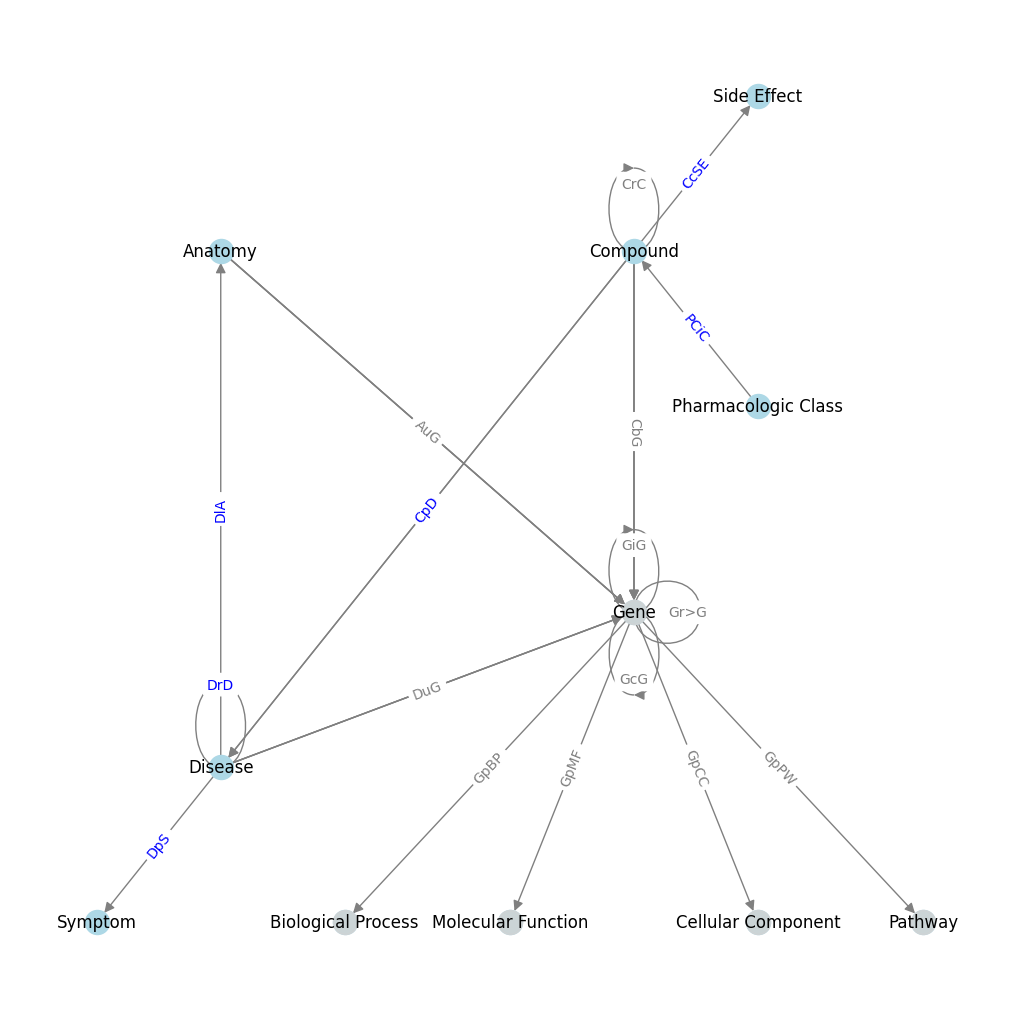

________________________________________________________________________________




In [10]:
# [Code: 10]

# Building the graph representing all the possible types of connections among the different node kinds
connectionTypeDF = edgesTypeDF[['metaedge','kind_source','kind_target']].drop_duplicates()
recapConnectionsG =  nx.from_pandas_edgelist(connectionTypeDF, 'kind_source', 'kind_target', edge_attr='metaedge', create_using=nx.MultiDiGraph())

# Drawing the graph structure with nodes and edges
if generateImages:
  plt.figure(figsize=(10, 10))
  pos = {'Gene':[0.5,-0.2],
         'Biological Process':[-0.2,-0.8],
         'Compound':[0.5,0.5],
         'Anatomy':[-0.5,0.5],
         'Disease':[-0.5,-0.5],
         'Molecular Function':[0.2,-0.8],
         'Pathway':[1.2,-0.8],
         'Cellular Component':[0.8,-0.8],
         'Pharmacologic Class':[0.8,0.2],
         'Side Effect':[ 0.8, 0.8],
         'Symptom':[ -0.8, -0.8]} # customized positions for all nodes
  nx.draw(recapConnectionsG, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrowstyle='-|>', arrowsize=15)
  unusedNodes = ['Gene', 'Biological Process', 'Cellular Component', 'Molecular Function', 'Pathway']
  nx.draw_networkx_nodes(recapConnectionsG, pos, nodelist=unusedNodes, node_color='lightgrey', alpha=0.8)
  usedEdges = {edge:metaedge for edge,metaedge in nx.get_edge_attributes(recapConnectionsG, 'metaedge').items() if metaedge in ['DpS', 'DrD', 'DlA', 'CpD', 'CcSE', 'PCiC']}
  unusedEdges = {edge:metaedge for edge,metaedge in nx.get_edge_attributes(recapConnectionsG, 'metaedge').items() if metaedge in ['AuG', 'DuG', 'CbG', 'GpBP', 'GpMF', 'GpCC', 'GpPW', 'CrC', 'GiG', 'GcG', 'Gr>G']}
  usedEdgeLabels = nx.draw_networkx_edge_labels(recapConnectionsG, pos, edge_labels=usedEdges ,  font_color='blue')
  unusedEdgeLabels = nx.draw_networkx_edge_labels(recapConnectionsG, pos, edge_labels=unusedEdges ,  font_color='grey')
  if overwriteSavings:
    plt.savefig('Outputs/Graph_structure.png', dpi=300, bbox_inches='tight')
  section("Graph representing all the possible types of connections among the different node kinds:")
  plt.show()
  section('end')
else:
  print("Warning: turn generateImages setting to True in order to visualize the graph structure!")

### 3.2 - Extracting diagnoses
The function we developed is tested with random patient profiles, the results are presented in visual format.
***
Hypoteses:
- The patient comes to chatDOC recognizing of one and only one main symptom
- The patient is eventually also aware of other secondary symptoms (which may be uncorrelated with the main one, thus not considered to obtain the final diagnosis) and already diagnosed diseases
- The patient has one and only one disease to be diagnosed, if no significant symptoms are recognized which are not correlated to an already diagnosed disease, that diagnosis will be just confirmed.
- Disease-to-symptom edges mean that the particular disease necessarily implies the appeareance of all the connected symptoms (while not viceversa), thus the main symptoms are considered to be the ones triggered by a lower number of different diseases
- Compound-to-disease edges mean that the particular compound perfectly treats (at the same exact extent as all the other compounds connected to that disease node) the specific illness
- Compound-to-side-effect edges mean that the particular compound eventually casues the appearance of that specific side effect with an undefined constant probability, thus (being all side effects comparable by severeness) the best compound for a disease is determinable as the connected one with fewer possible side effects
- Disease-to-anatomy edges mean that the particular disease could affect the specific anatomy, thus the main anatomies are considered to be the ones affectable by a lower number of different diseases
- Disease-to-diseases edges connect pairs of diseases that could probably appear together in a patient, thus (if no univocal diagnosis is obtainable based on observed symptoms olny) eventually multiple possible diagnosis are ordered based on their eventual connections with already diagnosed diseases

A random patient's diagnosis scheme: ___________________________________________


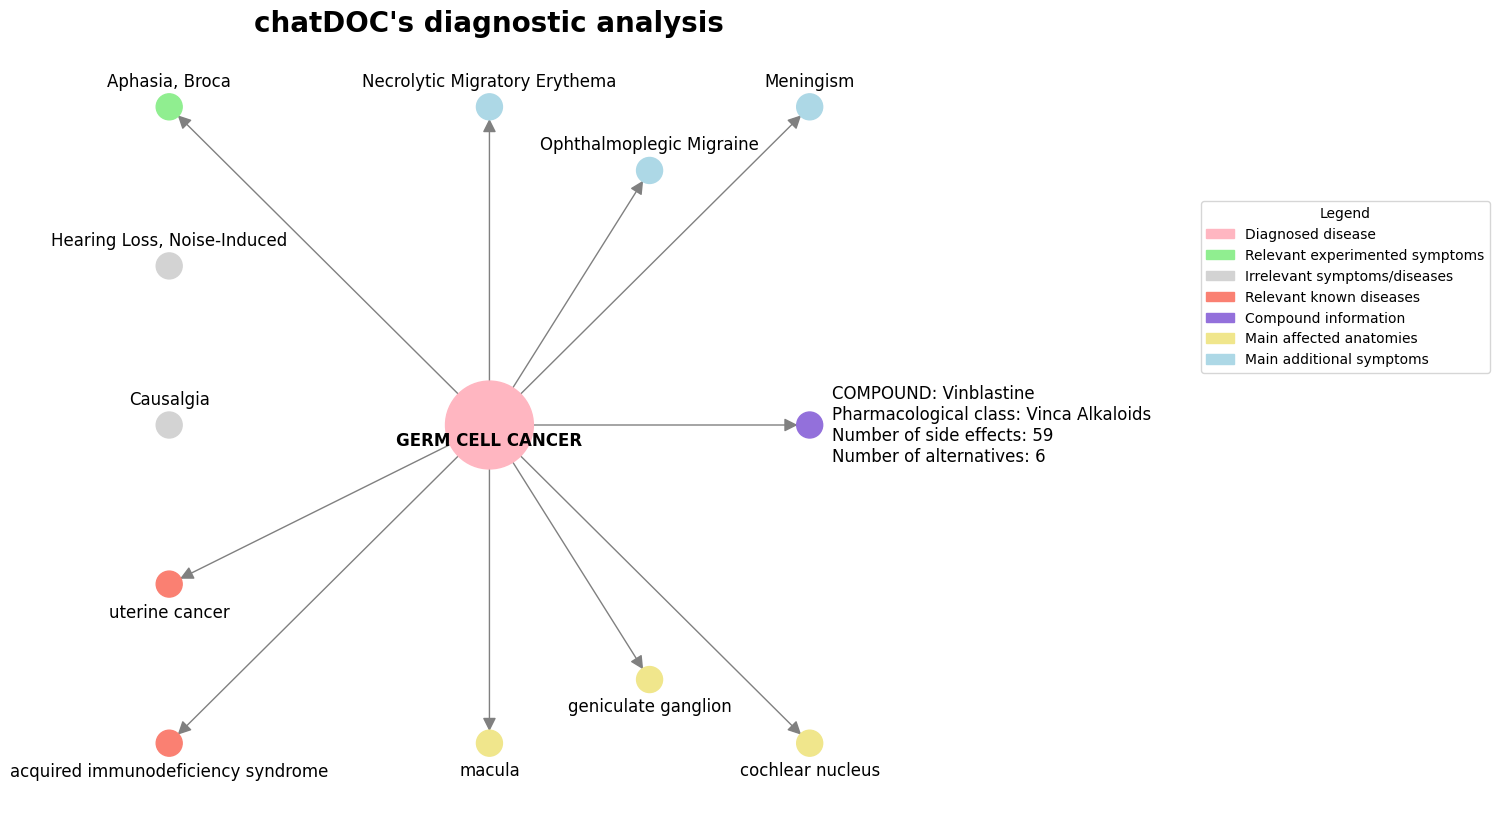

________________________________________________________________________________




In [53]:
# [Code: 11]

# Applying chatDOC and the related visualization function on patientRand-generated profiles
patient = patientRand(G,random.randint(1,4),random.randint(0,2),random.randint(0,2))
output = chatDOC(G,patient[0])
if output['diagnosis'] in patient[1] or set(output['possibleDiseases'])-patient[1] == set():
  if generateImages:
    section("A random patient's diagnosis scheme:")
    visualization = visualizeDOC(G, output)
    visualization.show()
    section('end')
  else:
    print("chatDOC output generated:", output)
else:
  print("Error: non-coherent diagnosis!")

### 3.3 - Interacting with chatDOC
The doctor-like function's chat-mode is tested.

Hi! How can I help you today? Which is your main symptom?	eye
There are 3 symptoms related to your description:
1 - Eye Pain
2 - Eye Hemorrhage
3 - Eye Manifestations
Please select the number of the main symptom you are actually experimenting:	4
Invalid slection, please input the number corresponding to the symptom of interest as from the above list!
Please select the number of the main symptom you are actually experimenting:	1
Your main symptom is then: Eye Pain !
Do you already recognize specific other symptoms?	[Y/N]	yes
Please specify all already recognized secondary symptoms ordered by relevance and separated by ';':	head; Symptom::D058447; diabete
There are 2 symptoms related to your description 'head':
1 - Coma, Post-Head Injury
2 - Headache
Please select the number of the secondary symptom you are actually experimenting:	2
The following inputs are not recognizable as symptoms: diabete !
Have you already been diagnosed with other diseases?	[Y/N]	dont know
Input not recognized, p

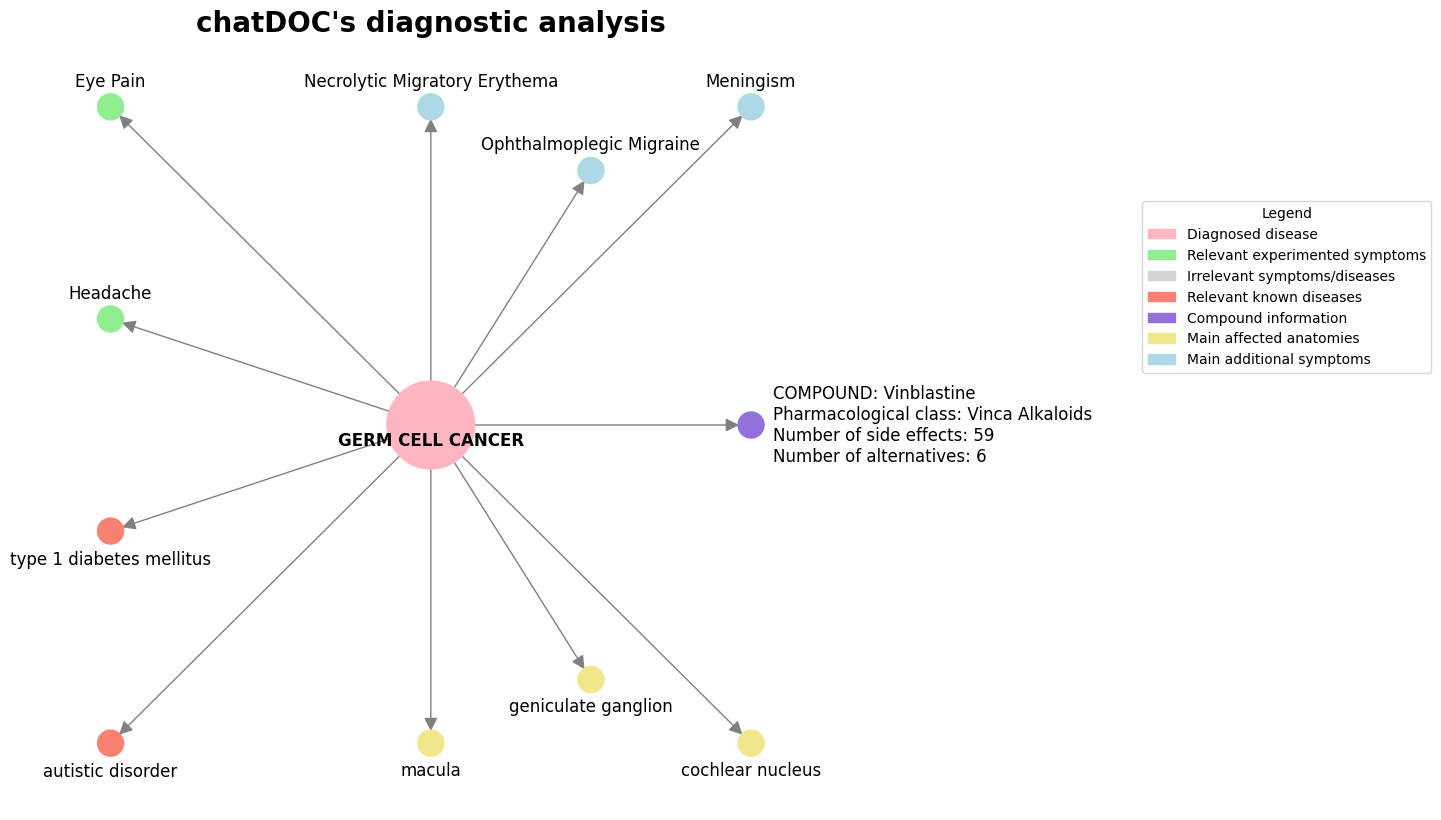

In [54]:
# [Code: 12]

# Applying chatDOC and the related visualization function on data directly given as input
output = chatDOC(G,None)
if generateImages:
  visualization = visualizeDOC(G, output)
  visualization.show()